In [283]:
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import tsai.all as tsai

sns.set()

from matplotlib.patches import Patch
from scipy.stats import spearmanr, pearsonr
from tqdm import tqdm

In [50]:
############## Import modules ##############
sys.path.append('../')

%load_ext autoreload
%autoreload 2

from modules import utils
from modules.attributions.attribution_config_dev import config as default_attr_config
from modules.attributions.attribution_processor import ClassificationProcessor
from modules.datasets import dataset_utils, pkl_loader, ucr_loader
from modules.networks import model_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
class OptionParser:
    def __init__(self):
        ########## Global settings #############
        self.verbose = True
        self.seed = 0
        ######### Dataset processing ###########
        self.root_path = "../../data/"
        self.dataset_name =  "CharacterTrajectories"
        self.dataset_file = "dataset.pickle"
        self.normalize = False
        self.standardize = True
        self.validation_split = 0.3
        self.is_channel_first = False
        ######### Experiment details ###########
        self.exp_path = 'dev'
        ####### Perform baseline model #########
        self.batch_size = 32

options = OptionParser()

In [174]:
########## Global settings #############
np.random.seed(options.seed)
torch.manual_seed(options.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dir, result_dir = utils.maybe_create_dirs(
    options.dataset_name, root='../../', dirs=['models', 'results'],
    exp=options.exp_path, return_paths=True, verbose=options.verbose)

Found existing directory: ../../models/dev/CharacterTrajectories
Found existing directory: ../../results/dev/CharacterTrajectories


In [175]:
######### Dataset processing ###########
dataset_dict = ucr_loader.get_datasets(options.root_path, prefix='**/')
split_id = None
try:
    trainX, trainY, testX, testY = ucr_loader.load_data(dataset_dict[options.dataset_name])
    valX, valY = None, None
except:
    trainX, trainY, valX, valY, testX, testY = pkl_loader.load_data(
        os.path.join(options.root_path, options.dataset_name, options.dataset_file),
        is_channel_first=options.is_channel_first)
if valX is not None:
    trainX, trainY, split_id = dataset_utils.fuse_train_val( trainX, trainY, valX, valY)
trainX, trainY, testX, testY = dataset_utils.preprocess_data(
    trainX, trainY, testX, testY, normalize=options.normalize,
    standardize=options.standardize, channel_first=True)
if split_id is None:
    trainX, trainY, valX, valY = dataset_utils.perform_datasplit(trainX, trainY, test_split=options.validation_split)
else:
    trainX, trainY, valX, valY = dataset_utils.unfuse_train_val(trainX, trainY, split_id)
channels, timesteps = trainX.shape[1:]
n_classes = len(np.unique(trainY))

if options.verbose:
    print('TrainX:', trainX.shape)
    print('ValX:', valX.shape)
    print('TestX:', testX.shape)
    print('Classes:', n_classes)

TrainX: (995, 3, 182)
ValX: (427, 3, 182)
TestX: (1436, 3, 182)
Classes: 20


In [176]:
######### Data loader creation #########
trainloader = model_utils.create_dataloader(
    trainX, trainY, batch_size=options.batch_size, shuffle=True, drop_last=False, num_workers=8)
valloader = model_utils.create_dataloader(
    valX, valY, batch_size=options.batch_size, shuffle=False, drop_last=False, num_workers=8)

In [244]:
######## Randomized methods ############
def randomize_block(m):
    if isinstance(m, (torch.nn.Conv1d, torch.nn.Linear)):
        m.reset_parameters()
    else:
        for layer in m:
            if isinstance(layer, (torch.nn.Conv1d, torch.nn.Linear)):
                layer.reset_parameters()
                
def randomize_setups(blocks):
    setups = {}
    possible_blocks = blocks
    for i, s in enumerate(['Bottom', 'Top', 'Random']):
        if i > 0:
            possible_blocks = possible_blocks[::-1]
        setups[f'{s}_{0}'] = [] # original
        for j in range(1, len(blocks)+1):
            if i != 2:
                setups[f'{s}_{j}'] = possible_blocks[:j]
            else:
                setups[f'{s}_{j}'] = [possible_blocks[j-1]]
    return setups

In [245]:
model_setup = 'InceptionTime_batch-' + str(options.batch_size)
model_path = os.path.join(model_dir, model_setup + '.pt')
model = tsai.InceptionTime(channels, n_classes).to(device)
blocks = [model.inceptionblock.inception[0].convs, model.inceptionblock.inception[0].maxconvpool,
        model.inceptionblock.inception[1].convs, model.inceptionblock.inception[0].maxconvpool,
        model.inceptionblock.inception[2].convs, model.inceptionblock.inception[0].maxconvpool,
        model.inceptionblock.inception[3].convs, model.inceptionblock.inception[0].maxconvpool, model.fc]
setups = randomize_setups(blocks)

In [246]:
def compute_randomized_attrs(dataX, dataY, setups, model, model_path, default_attr_config, save=None):
    results = {}
    for s in tqdm(setups, desc='Setup'):
        model.load_state_dict(torch.load(model_path))
        for b in setups[s]:
            randomize_block(b)
        model.eval()
        attrProcessor = ClassificationProcessor(model, dataX.shape[1:], default_attr_config, load=False)
        attrProcessor.compute_all_attributions(dataX, dataY, None)
        m = list(attrProcessor.approaches)[0]
        pred = model_utils.predict(model, torch.Tensor(dataX)).numpy()
        results[s] = {'pred': pred, 'attr': attrProcessor.approaches[m]['attr']}
    if save is not None:
        with open(save, 'wb') as f:
            pickle.dump(results, f)
    return results

rand_attrs = compute_randomized_attrs(testX[:1], testY[:1], setups, model, model_path,
                         {'Timereise': default_attr_config['Timereise']},
                         save=os.path.join(result_dir, 'Randomized_attrs.pickle'))

Setup: 100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


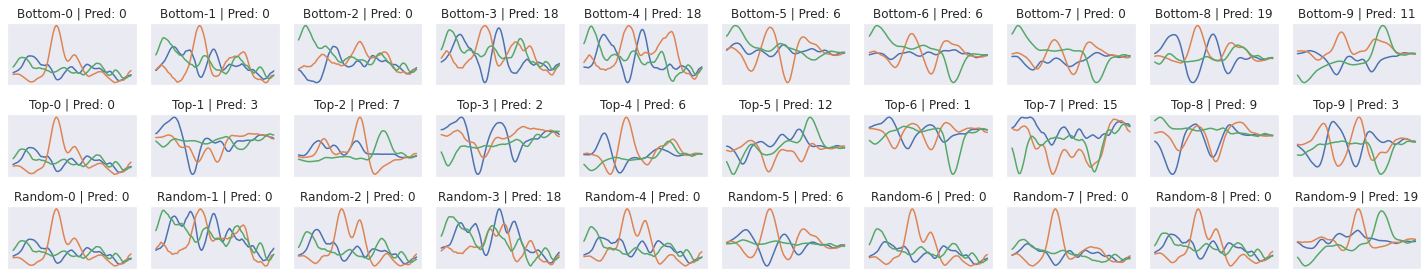

In [247]:
def plot_grid(attrs, idx=0, save=None):
    setups = list(attrs)
    ncols = len(setups)//3
    fig, axes = plt.subplots(figsize=(20, 4), nrows=3, ncols=ncols, sharex=True, sharey=True)
    ax = axes.flat
    
    for i, setup in enumerate(setups):
        ax[i].set_title(f'{setup.replace("_", "-")} | Pred: {attrs[setup]["pred"][idx]}')
        ax[i].plot(attrs[setup]['attr'][idx].T)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
            
    plt.tight_layout()
    
    if save is not None:
        plt.savefig(os.path.join(save, 'Randomized_attrs.png'), dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    
plot_grid(rand_attrs, idx=0, save=result_dir)

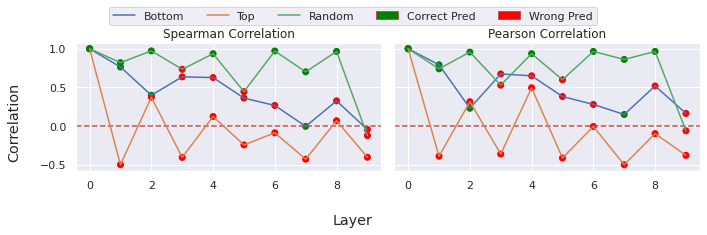

In [292]:


def compute_corr(attrs):
     result = {}
     ref = attrs[list(attrs)[0]]['attr'].reshape(-1)
     for m in sorted(attrs):
          result[m] = []
          spear = spearmanr(ref, attrs[m]['attr'].reshape(-1))[0]
          pears = pearsonr(ref, attrs[m]['attr'].reshape(-1))[0]
          result[m] = {'spearmanr': spear, 'pearsonr': pears}
     return result

def plot_corrs(corrs, attrs, save=None):
     n_layer = len(setups)//3
     fig, ax = plt.subplots(figsize=(10, 3), ncols=2, sharey=True, sharex=True)
     for i, key in enumerate(['Spearman Correlation', 'Pearson Correlation']):
          ax[i].set_title(key)
          ax[i].axhline(y=0, color='r', linestyle='--')
          metric = 'spearmanr' if i == 0 else 'pearsonr'
          for key2 in ['Bottom', 'Top', 'Random']:
               vals = [corrs[k][metric] for k in list(corrs) if key2 in k]
               if i == 0:
                    ax[i].plot(vals, label=key2)
               else:
                    ax[i].plot(vals)
               preds = [attrs[k]['pred'] for k in list(attrs) if key2 in k]
               correct = ['green' if p == preds[0] else 'red' for p in preds]
               ax[i].scatter(np.arange(n_layer), vals, c=correct)

     fig.supxlabel('Layer')
     fig.supylabel('Correlation')
     lgd = fig.legend(loc='upper center', bbox_to_anchor=(.5, 1.06), ncol=n_layer)
     handles, labels = lgd.figure.axes[0].get_legend_handles_labels()
     handles.append(Patch(facecolor='green', edgecolor='r'))
     labels.append("Correct Pred")
     handles.append(Patch(facecolor='red', edgecolor='r'))
     labels.append("Wrong Pred")
     lgd._legend_box = None
     lgd._init_legend_box(handles, labels)
     lgd._set_loc(lgd._loc)
     lgd.set_title(lgd.get_title().get_text())

     plt.tight_layout()

     if save is not None:
          fig.savefig(os.path.join(save, 'Randomized_corrs.png'), dpi=300, bbox_inches='tight', pad_inches=0.1)
     plt.show()

rand_corrs = compute_corr(rand_attrs)
plot_corrs(rand_corrs, rand_attrs, result_dir)